In [1]:
# the training part of the code is modified based on:
# https://medium.com/@rebirth4vali/implementing-matrix-factorization-technique-for-recommender-systems-from-scratch-7828c9166d3c

import pandas as pd
from scipy.sparse import csr_matrix
import time, numpy as np
import matplotlib.pyplot as plt

## Construct data

In [2]:
raw_train = pd.read_csv("interactions_train.csv")
raw_valid = pd.read_csv("interactions_validation.csv")
raw_test = pd.read_csv("interactions_test.csv")
raw_train

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
698896,926904,457971,2018-12-18,5.0,13681,141067
698897,2002312797,27208,2018-12-18,5.0,14897,99787
698898,1290903,131607,2018-12-18,5.0,11605,76163
698899,226867,363072,2018-12-18,5.0,3604,29101


In [3]:
S_train = csr_matrix(
    (raw_train.rating.values, (raw_train.u.values, raw_train.i.values)),
    shape=(max(raw_train.u.max(), raw_valid.u.max(), raw_test.u.max()) + 1,
           max(raw_train.i.max(), raw_valid.u.max(), raw_test.i.max()) + 1)).toarray()

S_train.shape

(25076, 178265)

## Training

In [4]:
class MatrixFactorization():

  def __init__(self, S_matrix, n_factors, eta=0.01, lamda=0.01, n_iter=100, verbose = True):
    self.S = S_matrix
    self.n_users, self.n_recipes = S_matrix.shape
    self.non_zero_user_ind, self.non_zero_recipe_ind = S_matrix.nonzero()
    self.n_interac = len(S_matrix[np.where(S_matrix != 0)])
    self.index_list = list(range(self.n_interac))
    self.n_factors = n_factors # defines the orther dimension of U & R matrix
    self.eta = eta # controls the learning steps
    self.lamda = lamda # controls the weights of regularizations
    self.n_iter = n_iter
    self.mse_lst = [] # for graph
    self.wait = 10 # number of epoches(that mse does not change) we wait befor early stoping
    self.tol = 1e-3
    self.n_iter_no_change = 0
    self.stop = False
    self.total_training_time = 0 # to recode how long does it take to train
    self.verbose = verbose

  def initialize(self, ):
    self.now = time.time()
    # initialize user & recipe vectors
    self.U = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
    self.R = np.random.normal(scale=1/self.n_factors, size=(self.n_recipes, self.n_factors))

  def predict(self, u, r):
    return np.inner(self.U[u], self.R[r])

  def update_UR(self, difference, u, r):
    # update with gradient
    self.U[u, :] += self.eta*(difference*self.R[r, :] - self.lamda*self.U[u, :])
    self.R[r, :] += self.eta*(difference*self.U[u, :] - self.lamda*self.R[r, :])

  def fit(self, ):
    self.initialize()
    for epoch in range(1, self.n_iter):
      np.random.shuffle(self.index_list)
      if self.stop == False:
        for index in self.index_list:
          # Extracting user item information indices in which we have a rating
          u, r = self.non_zero_user_ind[index], self.non_zero_recipe_ind[index]
          pred_rat = self.predict(u, r)
          error = self.S[u, r]-pred_rat
          self.update_UR(error, u, r)
        self.evaluate_the_model(epoch)
        self.early_stopping(epoch)

  def evaluate_the_model(self, epoch):
    tot_square_error = 0
    for index in self.index_list:
      # Extracting user item information indices in which we have a rating
      u, r = self.non_zero_user_ind[index], self.non_zero_recipe_ind[index]
      pred_rat = self.predict(u, r)
      tot_square_error += (self.S[u, r]-pred_rat)**2
    mse = tot_square_error/self.n_interac
    # mse += self.compute_regularization(self.U)
    # mse += self.compute_regularization(self.R)
    self.mse_lst.append(mse)
    if self.verbose:
      print(f"---> Epoch {epoch}")
      temp = np.round(time.time()-self.now, 3)
      print(f"ave mse {np.round(self.mse_lst[-1], 5)} ===> Total training time: {temp} seconds.")

  def compute_regularization(self, M):
    result = 0
    for i in range(M.shape[0]):
      result += np.linalg.norm(M[i])**2
    return result

  def early_stopping(self, epoch):
    if epoch >= 2:
      if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
        if self.wait == self.n_iter_no_change:
          temp = np.round(time.time()-self.now, 3)
          self.total_training_time = temp
          print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
          self.stop = True
          self.conv_epoch_num = epoch
        self.n_iter_no_change += 1
      else:
        self.n_iter_no_change = 0

  def get_training_time(self, ):
    return self.total_training_time

  def plot_the_score(self, ):
    plt.figure(figsize=(18,6))
    plt.plot(range(1, 1+len(self.mse_lst)), self.mse_lst, marker='o')
    plt.title("MSE vs epochs", fontsize=20)
    plt.xlabel('Number of epochs', fontsize=18)
    plt.ylabel('mean square error', fontsize=18)
    plt.xticks(range(1, self.conv_epoch_num+5), fontsize=15, rotation=90)
    plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst),15), fontsize=15)
    plt.show()


### find hyperparameter based on validation accuracy

In [5]:
def find_test_mse(MF, u, i, rating):
  begin_prediction = time.time()
  test_mse = 0
  for user, recipe, rate in zip(u, i, rating):
    pred = MF.predict(user, recipe)
    test_mse += (rate - pred)**2

  test_mse = test_mse / len(u)
  end_prediction = time.time()
  time_used_for_prediction = np.round(end_prediction - begin_prediction, 3)

  return test_mse, time_used_for_prediction

In [6]:
factors_list = [2, 50, 100, 150, 200, 300]
train_mse_list = []
valid_mse_list = []
best_valid_mse = 1000
best_MF = 0
best_MF_training_time = 0
best_factors = 0

for factors in factors_list:
  MF = MatrixFactorization(S_train, factors, verbose=False)
  MF.fit()
  train_mse_list.append(MF.mse_lst[-1])
  valid_mse, _ = find_test_mse(MF, raw_valid.u.values, raw_valid.i.values,
                               raw_valid.rating.values)
  valid_mse_list.append(valid_mse)
  if valid_mse < best_valid_mse:
    best_valid_mse = valid_mse
    best_MF = MF
    best_MF_training_time = MF.get_training_time()
    best_factors = factors

Convergence after 63 epochs time took: 1233.661 seconds.
Convergence after 71 epochs time took: 1330.87 seconds.
Convergence after 73 epochs time took: 1387.954 seconds.
Convergence after 74 epochs time took: 1544.581 seconds.
Convergence after 75 epochs time took: 1612.374 seconds.
Convergence after 76 epochs time took: 1657.11 seconds.


In [7]:
print(best_factors, best_valid_mse, best_MF_training_time)

300 19.613962936376506 1657.11


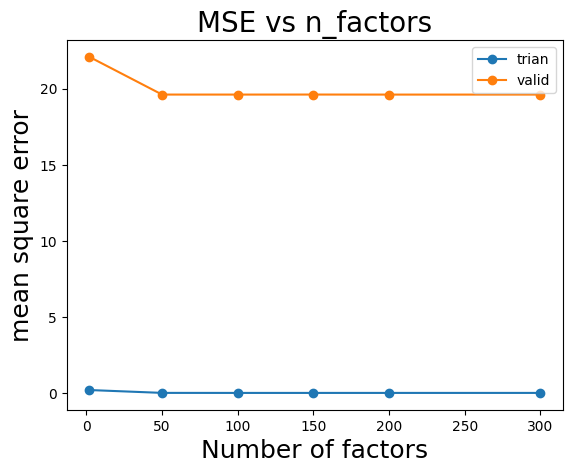

In [8]:
plt.plot(factors_list, train_mse_list, marker='o', label = "trian")
plt.plot(factors_list, valid_mse_list, marker='o', label = "valid")
plt.legend()
plt.title("MSE vs n_factors", fontsize=20)
plt.xlabel('Number of factors', fontsize=18)
plt.ylabel('mean square error', fontsize=18)
plt.show()

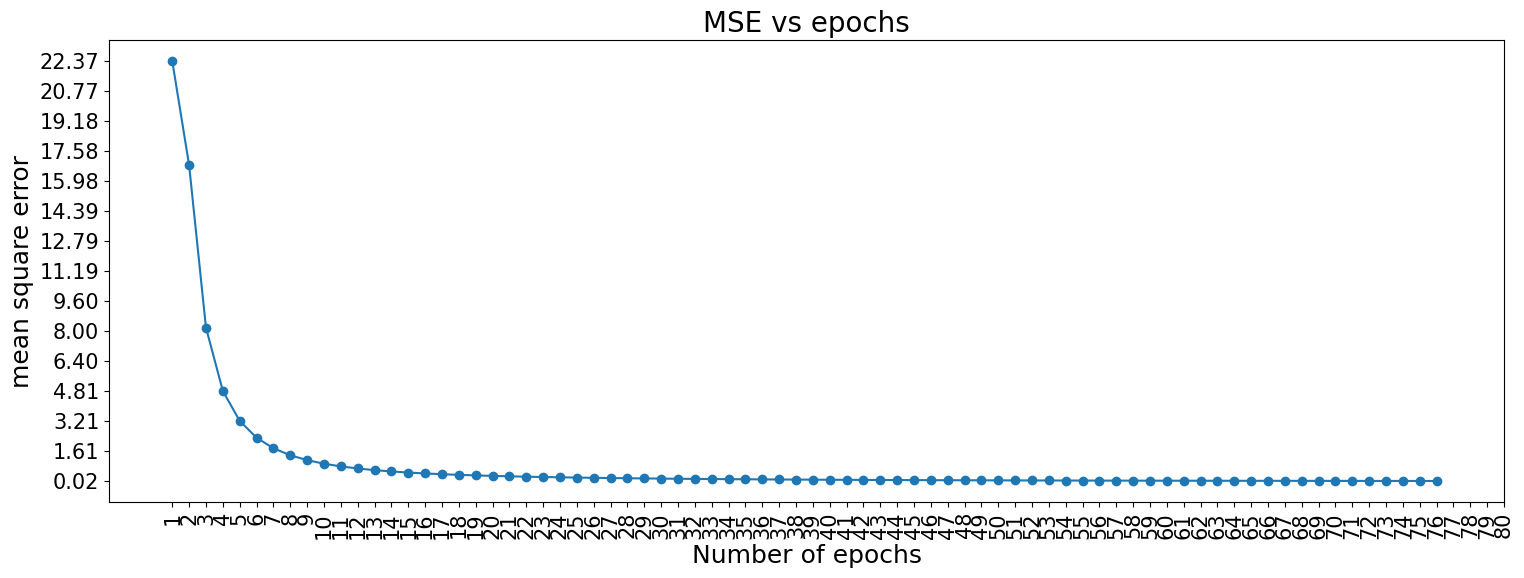

In [9]:
best_MF.plot_the_score()

## Testing

In [10]:
test_mse, time_used_for_prediction = find_test_mse(best_MF, raw_test.u.values,
                                                   raw_test.i.values,
                                                   raw_test.rating.values)

print(f"ave test mse {np.round(test_mse, 5)} ===> Total testing time: {time_used_for_prediction} seconds.")

ave test mse 19.54326 ===> Total testing time: 0.067 seconds.


## rewrite test_mse

In [11]:
def find_test_mse2(MF, u, i, rating):
  begin_prediction = time.time()
  test_mse = 0

  r_mean = np.mean(MF.R[np.unique(raw_train.i.values), :], axis = 0)
  for user, recipe, rate in zip(u, i, rating):
    pred = np.inner(MF.U[user], r_mean)
    test_mse += (rate - pred)**2

  test_mse = test_mse / len(u)
  end_prediction = time.time()
  time_used_for_prediction = np.round(end_prediction - begin_prediction, 3)

  return test_mse, time_used_for_prediction

In [12]:
factors_list = [2, 50, 100, 150, 200, 300]
train_mse_list = []
valid_mse_list = []
best_valid_mse = 1000
best_MF = 0
best_MF_training_time = 0
best_factors = 0

for factors in factors_list:
  MF = MatrixFactorization(S_train, factors, verbose=False)
  MF.fit()
  train_mse_list.append(MF.mse_lst[-1])
  valid_mse, _ = find_test_mse2(MF, raw_valid.u.values, raw_valid.i.values,
                               raw_valid.rating.values)
  valid_mse_list.append(valid_mse)
  if valid_mse < best_valid_mse:
    best_valid_mse = valid_mse
    best_MF = MF
    best_MF_training_time = MF.get_training_time()
    best_factors = factors

Convergence after 61 epochs time took: 1036.37 seconds.
Convergence after 72 epochs time took: 1261.024 seconds.
Convergence after 73 epochs time took: 1404.741 seconds.
Convergence after 74 epochs time took: 1644.441 seconds.
Convergence after 75 epochs time took: 1792.573 seconds.
Convergence after 76 epochs time took: 1714.926 seconds.


In [13]:
print(best_factors, best_valid_mse, best_MF_training_time)

300 2.021427677187594 1714.926


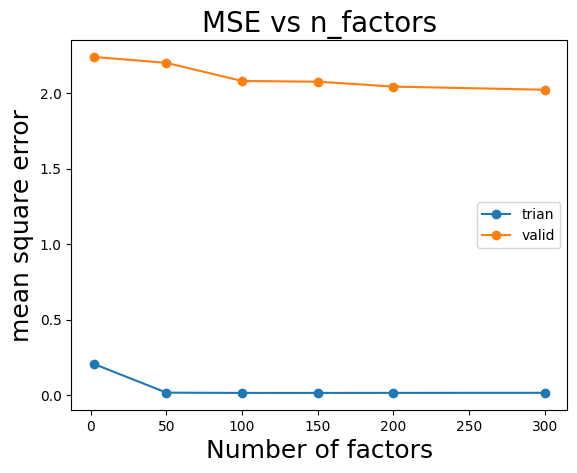

In [14]:
plt.plot(factors_list, train_mse_list, marker='o', label = "trian")
plt.plot(factors_list, valid_mse_list, marker='o', label = "valid")
plt.legend()
plt.title("MSE vs n_factors", fontsize=20)
plt.xlabel('Number of factors', fontsize=18)
plt.ylabel('mean square error', fontsize=18)
plt.show()

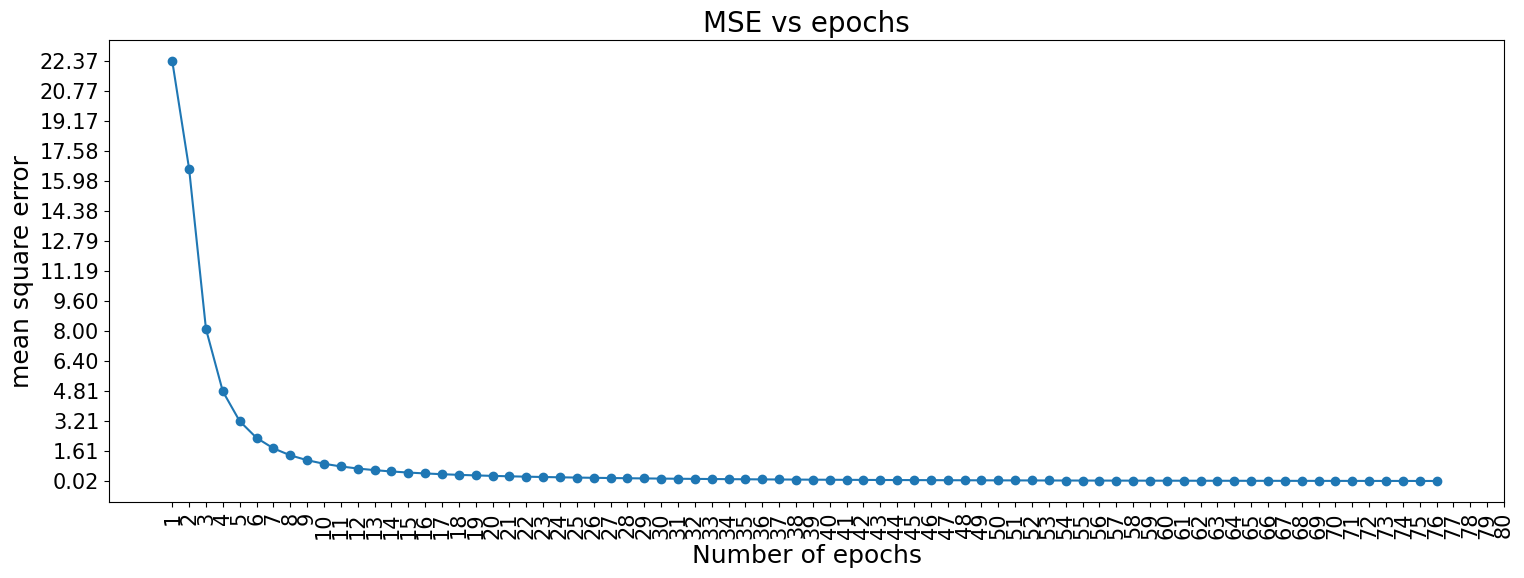

In [15]:
best_MF.plot_the_score()

In [16]:
test_mse, time_used_for_prediction = find_test_mse2(best_MF, raw_test.u.values,
                                                    raw_test.i.values,
                                                    raw_test.rating.values)

print(f"ave test mse {np.round(test_mse, 5)} ===> Total testing time: {time_used_for_prediction} seconds.")

ave test mse 2.60858 ===> Total testing time: 0.395 seconds.
